## Импорт зависимостей

In [1]:
import plotly.graph_objects as go
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from requests import Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
from datetime import datetime, timezone
import json

## Yahoo Finance BTC-USD Dataset

### Работа с dataset

Загрузим Yahoo Finance BTC_USD OHLC dataset

In [ ]:
!wget 'https://www.dropbox.com/scl/fi/4yrrr8d4jtjy121tpuubt/BTC-USD.csv?rlkey=3r3ig8pd8hh4nwznm4q5hex9p&dl=1' -O 'yahoo-finance-BTC-USD.csv'

Конвертируем поле 'Date' к типу datetime и избавимся от 'Adj Close' из-за того, что в большинстве случаев 'Adj Close' совпадает с 'Close'. Так же исключаем 'Volume' из-за недостаточной точности, далее мы получим более точные значения.

In [3]:
yahoo_df = pd.read_csv('yahoo-finance-BTC-USD.csv')
yahoo_df['Date'] = pd.to_datetime(yahoo_df['Date'], utc=True).dt.tz_convert(None)
yahoo_df.rename(columns={'Date': 'date', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close'}, inplace=True)
yahoo_df = yahoo_df.drop(columns=['Adj Close', 'Volume'])

Dataset после очистки

In [4]:
yahoo_df.head()

,date,open,high,low,close
0,2015-01-01,320.434998,320.434998,314.002991,314.248993
1,2015-01-02,314.079010,315.838989,313.565002,315.032013
2,2015-01-03,314.846008,315.149994,281.082001,281.082001
3,2015-01-04,281.145996,287.230011,257.612000,264.195007
4,2015-01-05,265.084015,278.341003,265.084015,274.473999


Добавим более точный Volume, а так же Market Cap для каждого дня: для этого через api получим недостающие данные через открытое API сервиса СoinGecko

In [5]:
fsym, tsym = 'bitcoin', 'usd'
start_date, end_date = '2016-01-01', '2023-11-19'
url = f'https://api.coingecko.com/api/v3/coins/{fsym}/market_chart/range'

parameters = {
    'vs_currency': tsym,
    'from': int(datetime.strptime(start_date, '%Y-%m-%d').replace(tzinfo=timezone.utc).timestamp()),
    'to': int(datetime.strptime(end_date, '%Y-%m-%d').replace(tzinfo=timezone.utc).timestamp()),
    'precision': 'full',
}
headers = {
    'Accepts': 'application/json',
}

session = Session()
session.headers.update(headers)
try:
    response = session.get(url, params=parameters)
    data = json.loads(response.text)
    volume_mcap_df = pd.merge(
        pd.DataFrame(data['total_volumes'], columns=['date', 'volume']),
        pd.DataFrame(data['market_caps'], columns=['date', 'market cap']),
        how='left', on='date'
    )
    volume_mcap_df['date'] = pd.to_datetime(volume_mcap_df['date'], unit='ms', utc=True).dt.tz_convert(None)
except (ConnectionError, Timeout, TooManyRedirects) as e:
    print(e)

Полученные 'volume' и 'market cap' значения

In [6]:
volume_mcap_df.head()

,date,volume,market cap
0,2016-01-01,1.338782e+09,6.530622e+09
1,2016-01-02,7.698691e+08,6.530689e+09
2,2016-01-03,9.841860e+08,6.470199e+09
3,2016-01-04,1.021958e+09,6.522335e+09
4,2016-01-05,7.582093e+08,6.502629e+09


Так же добавим данные для dataset о базовом и котируемом тикерах

In [7]:
result_df = pd.merge(yahoo_df, volume_mcap_df, how='left', on='date').dropna().reset_index(drop=True)
result_df['base symbol'] = 'BTC'
result_df['quote symbol'] = 'USD'

Краткая сводка о данных

In [8]:
print("Общая информация о данных:")
print(result_df.info())

print("\nСтатистическое описание данных:")
result_df.describe()

Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2875 entries, 0 to 2874
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          2875 non-null   datetime64[ns]
 1   open          2875 non-null   float64       
 2   high          2875 non-null   float64       
 3   low           2875 non-null   float64       
 4   close         2875 non-null   float64       
 5   volume        2875 non-null   float64       
 6   market cap    2875 non-null   float64       
 7   base symbol   2875 non-null   object        
 8   quote symbol  2875 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 202.3+ KB
None

Статистическое описание данных:


,open,high,low,close,volume,market cap
count,2875.000000,2875.000000,2875.000000,2875.000000,2.875000e+03,2.875000e+03
mean,16540.493471,16930.630482,16118.353523,16551.866412,1.885031e+10,3.092307e+11
std,16167.694175,16563.242489,15719.250161,16166.287159,1.882770e+10,3.082118e+11
min,365.072998,374.950012,354.914001,364.330994,2.028832e+07,5.519407e+09
25%,4076.187500,4160.466309,3991.789917,4077.615845,2.615478e+09,6.941132e+10
50%,9533.784180,9711.889648,9347.593750,9538.024414,1.634042e+10,1.713683e+11
75%,26825.655274,27225.270508,26459.482422,26841.619140,2.904528e+10,5.203490e+11
max,67549.734375,68789.625000,66382.062500,67566.828125,1.788941e+11,1.278798e+12


Сохраним результирующий dataframe

In [9]:
result_df.to_csv(f"BTC-USD.csv", index=False)

### Анализ

Построим графики рыночной капитализации, объему торгов, волатильности, а так же свечной граф с ohlc информацией для каждой свечи каждого дня.

P.S
Для удобной и итеративной работы с графиками используется plotly, то есть используется html, js и могут быть проблемы с отображением, если notebook не trusted.

In [10]:
df = result_df
df['volatility'] = df['high'] - df['low']

market_cap_fig = go.Figure([go.Scatter(x=df['date'], y=df['market cap'], mode='lines', name='Market Cap')])
market_cap_fig.update_layout(title='Market Capitalization Over Time', xaxis_title='Date', yaxis_title='Market Cap')

volume_fig = go.Figure([go.Scatter(x=df['date'], y=df['volume'], mode='lines', name='Volume')])
volume_fig.update_layout(title='Trading Volume Over Time', xaxis_title='Date', yaxis_title='Volume')

volatility_fig = go.Figure([go.Scatter(x=df['date'], y=df['volatility'], mode='lines', name='Volatility')])
volatility_fig.update_layout(title='Volatility Over Time', xaxis_title='Date', yaxis_title='Volatility')

candlestick_fig = go.Figure(data=[go.Candlestick(x=df['date'],
                                                 open=df['open'],
                                                 high=df['high'],
                                                 low=df['low'],
                                                 close=df['close'])])
candlestick_fig.update_layout(title='Candlestick Chart', xaxis_title='Date', yaxis_title='Price', yaxis=dict(fixedrange=False))

market_cap_fig.show()
volume_fig.show()
volatility_fig.show()
candlestick_fig.show()

Построение распределения цен окончания торгов для каждого дня

In [11]:
import plotly.express as px

histogram_fig = px.histogram(df, x='close', nbins=100, title='Distribution of Close Prices')
histogram_fig.update_layout(xaxis_title='Close Price', yaxis_title='Frequency')

histogram_fig.show()


## Получение данных через CryptoCompare and CoinGecko APIs

### Реализация формирования dataset для spot

Реализация функции для получения ohlc для указанного spot и диапазона дат

P.S
Для работы с этой функции требуется api key, получить его можно здесь: https://min-api.cryptocompare.com/

In [12]:
def get_ohlc(fsym, tsym, start_date, end_date=datetime.now(timezone.utc).strftime('%Y-%m-%d')):
    api_key = 'your_api_key'
    url = 'https://min-api.cryptocompare.com/data/v2/histoday'
    headers = {'Accept': 'application/json', 'Authorization': 'Apikey ' + api_key}

    try:
        start_date = datetime.strptime(start_date, '%Y-%m-%d').replace(tzinfo=timezone.utc)
        end_date = datetime.strptime(end_date, '%Y-%m-%d').replace(tzinfo=timezone.utc)
    except ValueError as e:
        print(f"Ошибка в формате даты: {e}")
        return None

    all_data = []

    try:
        while start_date < end_date:
            delta_days = min((end_date - start_date).days, 2000)
            to_ts = int((start_date + timedelta(days=delta_days)).timestamp())
            params = {
                'fsym': fsym,
                'tsym': tsym,
                'limit': delta_days,
                'toTs': to_ts
            }
            response = requests.get(url, headers=headers, params=params)
            response.raise_for_status()
            data = response.json()
            all_data.extend(data['Data']['Data'])
            start_date += timedelta(days=delta_days+1)

        result_df = pd.DataFrame(all_data).drop(columns=['volumefrom', 'volumeto', 'conversionSymbol', 'conversionType'])
        result_df = result_df.rename(columns={'time': 'date'})
        result_df['date'] = pd.to_datetime(result_df['date'], unit='s', utc=True).dt.tz_convert(None)

        return result_df.dropna().reset_index(drop=True)

    except requests.RequestException as e:
        print(f"Ошибка HTTP запроса: {e}")
        return None
    except KeyError as e:
        print(f"Ошибка в ключах данных: {e}")
        return None
    except Exception as e:
        print(f"Произошла непредвиденная ошибка: {e}")
        return None


Пример

In [13]:
get_ohlc('ETH', 'USD', '2016-01-01', '2023-11-19')

,date,high,low,open,close
0,2016-01-01,0.9561,0.9279,0.9296,0.9339
1,2016-01-02,0.9650,0.9308,0.9339,0.9316
2,2016-01-03,0.9915,0.9239,0.9316,0.9695
3,2016-01-04,0.9793,0.9152,0.9695,0.9516
4,2016-01-05,0.9668,0.9348,0.9516,0.9504
...,...,...,...,...,...
2875,2023-11-15,2063.0900,1967.9000,1979.6600,2059.6300
2876,2023-11-16,2092.2700,1930.3600,2059.6300,1961.5400
2877,2023-11-17,1991.1800,1906.3700,1961.5400,1961.6100
2878,2023-11-18,1972.1500,1918.1500,1961.6100,1963.6700


Реализация функции для получения volume и market cap для указанного spot и диапазона дат

In [14]:
def get_volume_mcap(fsym, tsym, start_date, end_date=datetime.now(timezone.utc).strftime('%Y-%m-%d')):
    url = f'https://api.coingecko.com/api/v3/coins/{fsym}/market_chart/range'

    parameters = {
        'vs_currency': tsym,
        'from': int(datetime.strptime(start_date, '%Y-%m-%d').replace(tzinfo=timezone.utc).timestamp()),
        'to': int(datetime.strptime(end_date, '%Y-%m-%d').replace(tzinfo=timezone.utc).timestamp()),
        'precision': 'full',
    }
    headers = {
        'Accepts': 'application/json',
    }

    session = Session()
    session.headers.update(headers)
    try:
        response = session.get(url, params=parameters)
        data = json.loads(response.text)
        volume_mcap_df = pd.merge(
            pd.DataFrame(data['total_volumes'], columns=['date', 'volume']),
            pd.DataFrame(data['market_caps'], columns=['date', 'market cap']),
            how='left', on='date'
        )
        volume_mcap_df['date'] = pd.to_datetime(volume_mcap_df['date'], unit='ms', utc=True).dt.tz_convert(None)

        return volume_mcap_df
    except (ConnectionError, Timeout, TooManyRedirects) as e:
        print(e)
        return None

Пример

In [15]:
get_volume_mcap('bitcoin', 'usd', '2016-01-01', '2023-11-19')

,date,volume,market cap
0,2016-01-01,1.338782e+09,6.530622e+09
1,2016-01-02,7.698691e+08,6.530689e+09
2,2016-01-03,9.841860e+08,6.470199e+09
3,2016-01-04,1.021958e+09,6.522335e+09
4,2016-01-05,7.582093e+08,6.502629e+09
...,...,...,...
2875,2023-11-15,2.233092e+10,6.948453e+11
2876,2023-11-16,2.847973e+10,7.392158e+11
2877,2023-11-17,1.202333e+10,7.074887e+11
2878,2023-11-18,2.268392e+10,7.146520e+11


Реализация функции для получения результирующего crypto spot dataframe

In [19]:
def get_crypto_spot_df(spot, date):
    symbol_to_label = {'BTC': 'bitcoin',
                       'ETH': 'ethereum',
                       'XRP': 'ripple',
                       'XMR': 'monero',
                       'ADA': 'cardano',
                       'MATIC': 'matic-network',
                       'DOGE': 'dogecoin',
                       'USD': 'usd',
                       'EUR': 'eur'}

    ohlc_df = get_ohlc(spot['base'], spot['quote'], date['start'], date['end'])
    volume_mcap_df = get_volume_mcap(symbol_to_label[spot['base']],
                                     symbol_to_label[spot['quote']],
                                     date['start'], date['end'])

    result_df = pd.merge(ohlc_df, volume_mcap_df, how='left', on='date').dropna()
    result_df['base symbol'] = spot['base']
    result_df['quote symbol'] = spot['quote']

    return  result_df

Пример

In [20]:
get_crypto_spot_df({'base': 'BTC', 'quote': 'USD'}, {'start': '2016-01-01', 'end': '2023-11-19'})

,date,high,low,open,close,volume,market cap,base symbol,quote symbol
0,2016-01-01,437.95,425.86,429.95,433.99,1.338782e+09,6.530622e+09,BTC,USD
1,2016-01-02,437.43,430.73,433.99,433.72,7.698691e+08,6.530689e+09,BTC,USD
2,2016-01-03,434.14,423.09,433.72,430.70,9.841860e+08,6.470199e+09,BTC,USD
3,2016-01-04,435.26,428.60,430.70,433.32,1.021958e+09,6.522335e+09,BTC,USD
4,2016-01-05,435.25,428.87,433.32,431.20,7.582093e+08,6.502629e+09,BTC,USD
...,...,...,...,...,...,...,...,...,...
2875,2023-11-15,37977.31,35374.22,35551.21,37884.19,2.233092e+10,6.948453e+11,BTC,USD
2876,2023-11-16,37951.14,35512.38,37884.19,36162.42,2.847973e+10,7.392158e+11,BTC,USD
2877,2023-11-17,36780.63,35873.70,36162.42,36626.32,1.202333e+10,7.074887e+11,BTC,USD
2878,2023-11-18,36853.45,36212.85,36626.32,36591.19,2.268392e+10,7.146520e+11,BTC,USD


Формирование сrypto spot datasets для дальнейшего анализа, используются BTC и одни из самых популярных альткойнов.
В итоге получим 7 datasets, который сохраним локально для дальнейшей работы, а так же будем анализировать далее.

In [21]:
def create_spot(base, quote):
    return {'base': base, 'quote': quote}

def create_date_range(start, end):
    return {'start': start, 'end': end}

default_date_range = create_date_range('2016-01-01', '2023-11-19')

crypto_date = [
    ('BTC', default_date_range),
    ('ETH', default_date_range),
    ('XRP', default_date_range),
    ('XMR', default_date_range),
    ('ADA', create_date_range('2017-09-01', '2023-11-19')),
    ('MATIC', create_date_range('2017-10-01', '2023-11-19')),
    ('DOGE', default_date_range)
]

crypto_dfs = {
    f'{crypto}-USD': get_crypto_spot_df(create_spot(crypto, 'USD'), date_range)
    for crypto, date_range in crypto_date
}

for df_name in crypto_dfs.keys():
    crypto_dfs[df_name].to_csv(f"{df_name}.csv", index=False)

### Анализ

Общий график цен для BTC и ETH

In [22]:
dataframes = [crypto_dfs['BTC-USD'], crypto_dfs['ETH-USD']]

fig = go.Figure()

for dataframe in dataframes:
    dataframe['date'] = pd.to_datetime(dataframe['date'])

    fig.add_trace(go.Scatter(x=dataframe['date'], y=dataframe['close'],
                             mode='lines',
                             name=dataframe['base symbol'].iloc[0]))

fig.update_layout(title='Close Prices of BTC, ETH Over Time',
                  xaxis_title='Date',
                  yaxis_title='Close Price',
                  legend_title='Cryptocurrency')

fig.show()

Общий график цен для ETH и XMR

In [23]:
dataframes = [crypto_dfs['XMR-USD'], crypto_dfs['ETH-USD']]

fig = go.Figure()

for dataframe in dataframes:
    dataframe['date'] = pd.to_datetime(dataframe['date'])

    fig.add_trace(go.Scatter(x=dataframe['date'], y=dataframe['close'],
                             mode='lines',
                             name=dataframe['base symbol'].iloc[0]))

fig.update_layout(title='Close Prices of ETH, XMR Over Time',
                  xaxis_title='Date',
                  yaxis_title='Close Price',
                  legend_title='Cryptocurrency')

fig.show()

Общий график цен остальных альткойнов

In [24]:
dataframes = [crypto_dfs['ADA-USD'], crypto_dfs['XRP-USD'], crypto_dfs['MATIC-USD'], crypto_dfs['DOGE-USD']]

fig = go.Figure()

for dataframe in dataframes:
    dataframe['date'] = pd.to_datetime(dataframe['date'])

    fig.add_trace(go.Scatter(x=dataframe['date'], y=dataframe['close'],
                             mode='lines',
                             name=dataframe['base symbol'].iloc[0]))

fig.update_layout(title='Close Prices of ADA, XRP, MATIC, DOGE Over Time',
                  xaxis_title='Date',
                  yaxis_title='Close Price',
                  legend_title='Cryptocurrency')

fig.show()

Общий график капитализации для всех криптовалют из списка. Как можно видеть, хоть цена между валютами иногда отличается на порядок, разница в капитализации может быть куда меньше, ведь она зависит не только от цены, но и от Circulating Supply


In [25]:
dataframes = [df for df in crypto_dfs.values()]

fig = go.Figure()

for dataframe in dataframes:
    dataframe['date'] = pd.to_datetime(dataframe['date'])

    fig.add_trace(go.Scatter(x=dataframe['date'], y=dataframe['market cap'],
                             mode='lines',
                             name=dataframe['base symbol'].iloc[0]))

fig.update_layout(title='Market Caps of Cryptocurrencies Over Time',
                  xaxis_title='Date',
                  yaxis_title='Close Price',
                  legend_title='Cryptocurrency')

fig.show()

Матрица тепловой корреляции для всех криптовалют. Как можно видеть, криптовалюты сильно коррелируют друг с другом, поэтому диверсифицировать портфель довольно сложно

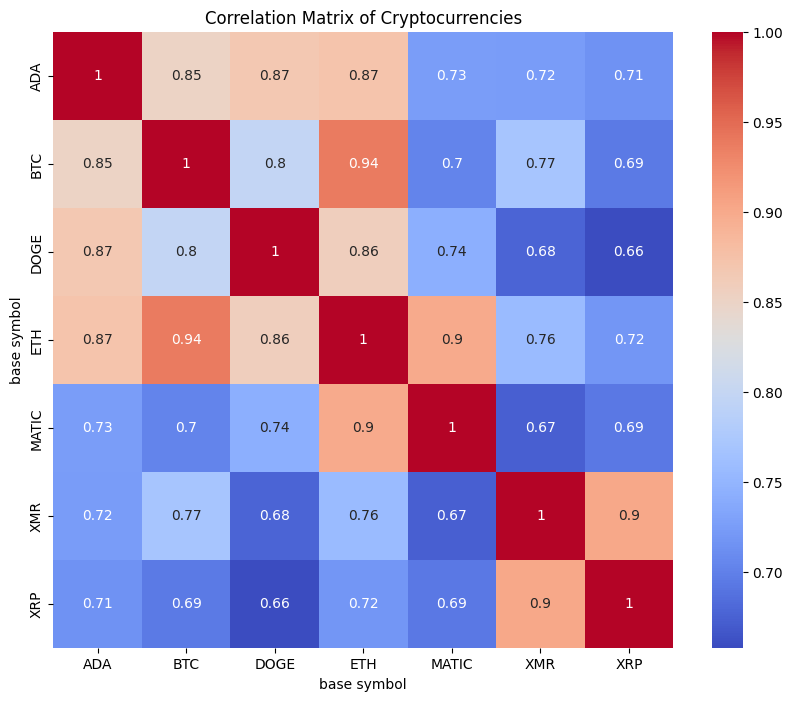

In [26]:
combined_df = pd.concat([df for df in crypto_dfs.values()], ignore_index=True)

correlation_matrix = combined_df.pivot_table(index='date', columns='base symbol', values='close').corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Cryptocurrencies")
plt.show()

### Подведение итогов

Изучив данные, а так же исследовав полученные графики, можно сделать вывод, что эти данные применимы в:
* Прогнозирование цен: Модели временных рядов, такие как ARIMA, LSTM (долгосрочная кратковременная память), и другие рекуррентные нейронные сети могут быть обучены на исторических данных для предсказания будущих цен или трендов криптовалют.
* Анализ настроений: Совмещение ценовых данных с данными из социальных медиа и новостных статей, чтобы анализировать, как настроения влияют на цены на криптовалюты. Модели обработки естественного языка (NLP), такие как BERT или GPT, могут быть использованы для извлечения настроений и их корреляции с движениями рынка.
* Обнаружение аномалий: Использование алгоритмов обнаружения аномалий для идентификации необычных паттернов в данных транзакций, что может указывать на мошенничество, манипуляции рынком или внезапные рыночные события.
* Рекомендательные системы: Разработка систем, которые рекомендуют криптовалюты для торговли или инвестирования на основе прошлой производительности и корреляционного анализа.
* Автоматическая торговля: Создание алгоритмических торговых систем, которые автоматически выполняют торговые операции на основе заданных моделей прогнозирования.
* Управление рисками: Моделирование и анализ рисков портфеля с использованием данных о волатильности и корреляции для оптимизации распределения активов и минимизации потенциальных потерь.
* Кластерный анализ: Группировка криптовалют на основе различных финансовых показателей для выявления схожих инвестиционных профилей или рыночных сегментов.